In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import re

from time import sleep
from tqdm import tqdm
from pykalman import KalmanFilter
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

In [2]:
# Function to calculate distance matrix between territories in two frames
def calculate_distance_matrix(frame1, frame2):
    coords_frame1 = df[df['frame'] == frame1][['pos_x', 'pos_y']].values
    coords_frame2 = df[df['frame'] == frame2][['pos_x', 'pos_y']].values
    distance_matrix = cdist(coords_frame1, coords_frame2)
    return distance_matrix, coords_frame1, coords_frame2

In [3]:
# Function to update territory_id based on optimal assignment
def update_territory_id(frame1, frame2):
    distance_matrix, coords_frame1, coords_frame2 = calculate_distance_matrix(frame1, frame2)
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    global new_id_counter  # Access the global counter
    
    # Update existing territories
    for idx1, idx2 in zip(row_ind, col_ind):
        territory_id_frame1 = df.loc[(df['frame'] == frame1)].iloc[idx1]['territory_id']
        df.loc[(df['frame'] == frame2) & (df['pos_x'] == coords_frame2[idx2, 0]) & (df['pos_y'] == coords_frame2[idx2, 1]), 'territory_id'] = territory_id_frame1
    
    # Handle unassigned territories in frame2
    unassigned_territories = set(range(len(coords_frame2))) - set(col_ind)
    for idx2 in unassigned_territories:
        new_territory_id = n_territories + new_id_counter
        new_id_counter += 1
        df.loc[(df['frame'] == frame2) & (df['pos_x'] == coords_frame2[idx2, 0]) & (df['pos_y'] == coords_frame2[idx2, 1]), 'territory_id'] = new_territory_id

In [4]:
predictions = glob.glob('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Personal/Artwork/Solitude/Interstitium/20230310_SE_Lek1_P2D3_DJI_0189/20230310_SE_Lek1_P2D3_DJI_0189DLC_dlcrnetms5_05_TerritoryDetectionP2Jul10shuffle1_50000_full.pickle')
data = pd.read_pickle(predictions[0])
frames = list(data.keys())[1:]

for idx,frame in enumerate(frames):
    fr = np.repeat(int(re.findall(r'\d+', frame)[0]),len(data[frame]['coordinates'][0][0]))
    pos_x = data[frame]['coordinates'][0][0][:,0]
    pos_y = data[frame]['coordinates'][0][0][:,1]
    territory_id = np.arange(0,len(data[frame]['coordinates'][0][0]))
    
    tmp = pd.DataFrame(np.array([fr,pos_x,pos_y,territory_id]).T, columns=['frame', 'pos_x', 'pos_y', 'territory_id'])
    if idx != 0:
        df = pd.concat((df, tmp), axis=0)
    else:
        df = tmp
        
# Total number of territories and counter to track new territory IDs
n_territories = np.max(df['territory_id'])
new_id_counter = 1

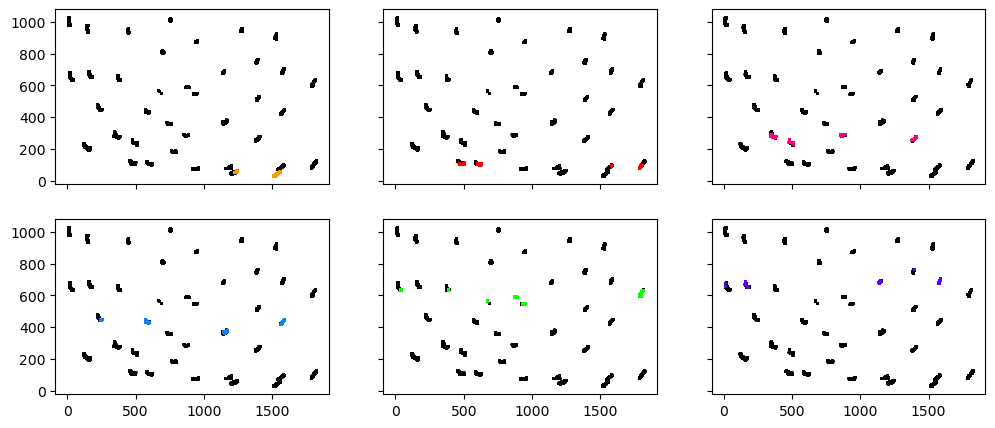

In [5]:
plot_territories = np.array([0,5,10,15,20,25])

fig,ax = plt.subplots(2,3, figsize=(12,5), sharex=True, sharey=True)

ax[0,0].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[0,0].scatter(df.loc[df['territory_id'] == plot_territories[0], 'pos_x'], df.loc[df['territory_id'] == plot_territories[0], 'pos_y'], s=1, c='#ff9900')
ax[0,1].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[0,1].scatter(df.loc[df['territory_id'] == plot_territories[1], 'pos_x'], df.loc[df['territory_id'] == plot_territories[1], 'pos_y'], s=1, c='#ff0000')
ax[0,2].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[0,2].scatter(df.loc[df['territory_id'] == plot_territories[2], 'pos_x'], df.loc[df['territory_id'] == plot_territories[2], 'pos_y'], s=1, c='#ff0080')
ax[1,0].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[1,0].scatter(df.loc[df['territory_id'] == plot_territories[3], 'pos_x'], df.loc[df['territory_id'] == plot_territories[3], 'pos_y'], s=1, c='#0486ff')
ax[1,1].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[1,1].scatter(df.loc[df['territory_id'] == plot_territories[4], 'pos_x'], df.loc[df['territory_id'] == plot_territories[4], 'pos_y'], s=1, c='#0aff02')
ax[1,2].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[1,2].scatter(df.loc[df['territory_id'] == plot_territories[5], 'pos_x'], df.loc[df['territory_id'] == plot_territories[5], 'pos_y'], s=1, c='#5f03ff')

plt.show()

In [6]:
# Update territory_id for successive frames in reverse order
unique_frames = df['frame'].unique()[::-1]
for current_frame, previous_frame in tqdm(zip(unique_frames[:-1], unique_frames[1:])):
    update_territory_id(current_frame, previous_frame)
    sleep(0.001)

5801it [04:33, 21.18it/s]


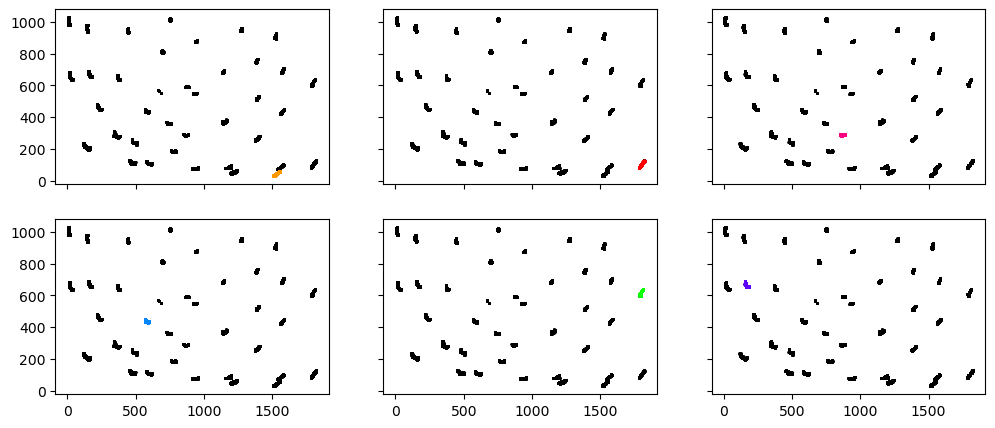

In [7]:
fig,ax = plt.subplots(2,3, figsize=(12,5), sharex=True, sharey=True)

ax[0,0].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[0,0].scatter(df.loc[df['territory_id'] == plot_territories[0], 'pos_x'], df.loc[df['territory_id'] == plot_territories[0], 'pos_y'], s=1, c='#ff9900')
ax[0,1].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[0,1].scatter(df.loc[df['territory_id'] == plot_territories[1], 'pos_x'], df.loc[df['territory_id'] == plot_territories[1], 'pos_y'], s=1, c='#ff0000')
ax[0,2].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[0,2].scatter(df.loc[df['territory_id'] == plot_territories[2], 'pos_x'], df.loc[df['territory_id'] == plot_territories[2], 'pos_y'], s=1, c='#ff0080')
ax[1,0].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[1,0].scatter(df.loc[df['territory_id'] == plot_territories[3], 'pos_x'], df.loc[df['territory_id'] == plot_territories[3], 'pos_y'], s=1, c='#0486ff')
ax[1,1].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[1,1].scatter(df.loc[df['territory_id'] == plot_territories[4], 'pos_x'], df.loc[df['territory_id'] == plot_territories[4], 'pos_y'], s=1, c='#0aff02')
ax[1,2].scatter(df['pos_x'], df['pos_y'], s=1, c='black')
ax[1,2].scatter(df.loc[df['territory_id'] == plot_territories[5], 'pos_x'], df.loc[df['territory_id'] == plot_territories[5], 'pos_y'], s=1, c='#5f03ff')

plt.show()

In [140]:
df.head()

,frame,pos_x,pos_y,territory_id
0,0.0,1550.786,64.241,0.0
1,0.0,1243.657,70.374,1.0
2,0.0,956.997,90.482,3.0
3,0.0,1197.299,97.827,4.0
4,0.0,1579.017,103.174,2.0


### Compute homography between an early and late frame within this video

In [135]:
df1 = df.loc[df['frame'] == np.min(df['frame']),:]
df2 = df.loc[df['frame'] == 2000,:]

df1 = df1[df1['territory_id'].isin(df2['territory_id'])].reset_index()
df2 = df2[df2['territory_id'].isin(df1['territory_id'])].reset_index()

df1 = df1.sort_values(by='territory_id')
df2 = df2.sort_values(by='territory_id')

In [136]:
src_points = df1.loc[:, ['pos_x','pos_y']].values
dest_points = df2.loc[:, ['pos_x','pos_y']].values

homography_matrix, status = cv2.findHomography(src_points, dest_points, method=cv2.RANSAC, ransacReprojThreshold=10)

In [137]:
src_points_homogeneous = np.column_stack((src_points, np.ones(len(src_points))))
transformed_points = np.dot(src_points_homogeneous, homography_matrix.T)

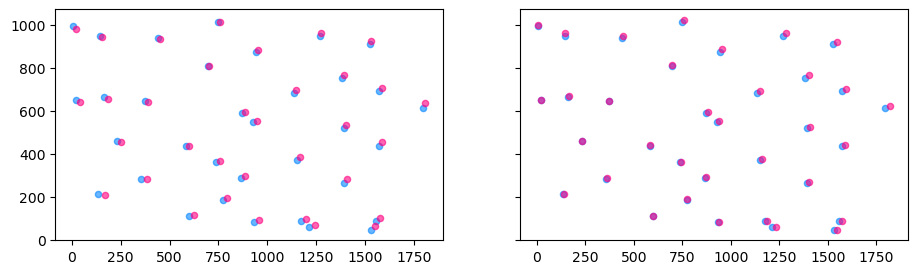

In [138]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(11,3), sharey=True)

ax1.scatter(dest_points[:,0], dest_points[:,1], s=20, c='#0486ff', alpha=0.6)
ax1.scatter(src_points[:,0], src_points[:,1], s=20, c='#ff0080', alpha=0.6)

ax2.scatter(dest_points[:,0], dest_points[:,1], s=20, c='#0486ff', alpha=0.6)
ax2.scatter(transformed_points[:,0], transformed_points[:,1], s=20, c='#ff0080', alpha=0.6)

plt.show()

In [139]:
before = np.linalg.norm(src_points - dest_points, axis=1)
after = np.linalg.norm(transformed_points[:,:2] - dest_points, axis=1)

rmse_before = np.sqrt(np.mean(before**2))
rmse_after = np.sqrt(np.mean(after**2))

rmse_before, rmse_after

(20.78342722968867, 13.269990606167177)